In [0]:
import nltk
import numpy as np
import pandas as pd
import pickle
import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import os
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### Step 1: Load and Preprocess Data

In [0]:
# load risk factors from local folder
txt_files_10Q = glob.glob('risk_factors/*.txt')
txt_files_10Q

['risk_factors/amzn_20181026_10q.txt',
 'risk_factors/aapl_20190731_10q.txt',
 'risk_factors/aapl_20190130_10q.txt',
 'risk_factors/aapl_20190501_10q.txt',
 'risk_factors/amzn_20180427_10q.txt',
 'risk_factors/aapl_20191031_10k.txt',
 'risk_factors/amzn_20190201_10k.txt',
 'risk_factors/amzn_20190726_10q.txt',
 'risk_factors/aapl_20180801_10q.txt',
 'risk_factors/amzn_20180202_10k.txt',
 'risk_factors/aapl_20180202_10q.txt',
 'risk_factors/aapl_20181105_10k.txt',
 'risk_factors/amzn_20190426_10q.txt',
 'risk_factors/aapl_20200129_10q.txt',
 'risk_factors/aapl_20180502_10q.txt',
 'risk_factors/amzn_20200131_10k.txt',
 'risk_factors/amzn_20191025_10q.txt',
 'risk_factors/amzn_20180727_10q.txt']

In [0]:
# extract ticker from the file name
ticker_list = []
for i in txt_files_10Q:
    ticker = re.sub("_.*$","",re.sub(".*/", "", i))
    if ticker not in ticker_list:
        ticker_list.append(ticker)
ticker_list.sort()
print(ticker_list) # list of companies

['aapl', 'amzn']


In [0]:
# generate the data dictionary 
ten_qs_by_ticker = {}
for i in ticker_list:
    ten_qs_by_ticker[i] = []

for i in ten_qs_by_ticker.keys():
    for item in txt_files_10Q:
        if re.sub("_.*$","",re.sub(".*/", "", item)) == i:
            d = {}
            d['file_date'] = str(item[-16:-4])
            with open(item, 'r') as file:
                d['file_clean'] = file.read().replace('\n', '')
            ten_qs_by_ticker[i].append(d)
    ten_qs_by_ticker[i] = sorted(ten_qs_by_ticker[i], key = lambda a: a['file_date'])

# show a sample file
# ten_qs_by_ticker['aapl'][-1]

{'file_date': '20200129_10q',
 'file_clean': '>Item 1A.Risk FactorsThe business, financial condition and operating results of the Company can be affected by a number of factors, whether currently known or unknown, including but not limited to those described in Part I, Item 1A of the 2019 Form 10-K under the heading “Risk Factors,” any one or more of which could, directly or indirectly, cause the Company’s actual financial condition and operating results to vary materially from past, or from anticipated future, financial condition and operating results. Any of these factors, in whole or in part, could materially and adversely affect the Company’s business, financial condition, operating results and stock price. There have been no material changes to the Company’s risk factors since the 2019 Form 10-K.Apple Inc. | Q1 2020 Form 10-Q | '}

### Step 2: Lemmatize and Remove Stop Words

In [0]:
# lematization
def lemmatize_words(words):
    """
    Lemmatize words 

    Parameters
    ----------
    words : list of str
        List of words

    Returns
    -------
    lemmatized_words : list of str
        List of lemmatized words
    """

    lemmatized_words = [WordNetLemmatizer().lemmatize(w, pos='v') for w in words]

    return lemmatized_words

In [0]:
# lemmatize words and remove stop words
word_pattern = re.compile('\w+')
lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_qs in ten_qs_by_ticker.items():
    for ten_q in tqdm(ten_qs, desc='Lemmatize {} 10-Qs'.format(ticker), unit='10-Q'):
        ten_q['file_lemma'] = lemmatize_words(word_pattern.findall(ten_q['file_clean']))
        ten_q['file_lemma'] = [word for word in ten_q['file_lemma'] if word not in lemma_english_stopwords]

ten_qs_by_ticker['aapl'][0].keys()

Lemmatize amzn 10-Qs: 100%|██████████| 9/9 [00:00<00:00, 11.9510-Q/s]


dict_keys(['file_date', 'file_clean', 'file_lemma'])

### Step 3: Calculate TF-IDF Values of Sentiment Words

In [0]:
# load sentiment vocab
sentiment_df = pd.read_csv('LoughranMcDonald_MasterDictionary_2018.csv') # From University of Notre Dame

sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')

sentiment_df.head()

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments
51,True,False,False,False,False,False,abdicate
54,True,False,False,False,False,False,abdication


In [0]:
# generate TF-IDF matrices
def get_tfidf(sentiment_words, docs, file_dates):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words
    file_dates: list of dates

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    term_list: list of sentiment terms and their tf-idf values.
    term_keys2: sentiment terms being added or removed compared to the previous period.
    """
    # generate TF-IDF matrices
    vectorizer = TfidfVectorizer(vocabulary = sentiment_words)
    tfidf = vectorizer.fit_transform(docs).toarray()
    
    term_list = []
    term_keys = []

    # this loop outputs a list of sentiment terms and their TF-IDF values
    for i in tfidf:
        #print(vectorizer.get_feature_names())
        key_tfidf = dict(zip(vectorizer.get_feature_names(), i))
        newDict = {key: value for (key, value) in key_tfidf.items() if value > 0 } # filter for value > 0 to focus on material outputs
        term_list.append(newDict)
        term_keys.append(list(newDict.keys()))
    
    term_keys2 = []

    # this loop outputs a list of terms that are being added or droped, compare to the previous period 
    for i in range(len(term_keys)):
        term_keys2.append({"Additional sentiment terms in period " + file_dates[i]: set(term_keys[i]).difference(set(term_keys[i-1]))})
        term_keys2.append({"Missing sentiment terms in period " + file_dates[i]: set(term_keys[i-1]).difference(set(term_keys[i]))})
        
    return tfidf, term_list, term_keys2

In [0]:
# Track changes in TF-IDF values
sentiment_tfidf_ten_qs = {}

sentiment_tfidf_ten_qs_terms = {}

sentiment_tfidf_ten_qs_terms_scores = {}

for ticker, ten_qs in ten_qs_by_ticker.items():
    lemma_docs = [' '.join(ten_q['file_lemma']) for ten_q in ten_qs]
    
    file_dates = [ten_q['file_date'] for ten_q in ten_qs]
    
    # run get_tfidf() function to generate TF-IDF matrices
    sentiment_tfidf_ten_qs[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs, file_dates)[0]
        for sentiment in sentiments}
    
    # for display of specific sentiment terms and their TF-IDF values
    sentiment_tfidf_ten_qs_terms[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs, file_dates)[2][2:]
        for sentiment in sentiments}

    # for display of terms that are being added or droped, compare to the previous period
    sentiment_tfidf_ten_qs_terms_scores[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs, file_dates)[1]
        for sentiment in sentiments}

pprint.pprint(sentiment_tfidf_ten_qs_terms_scores)
pprint.pprint(sentiment_tfidf_ten_qs_terms)



{'aapl': {'constraining': [{'commitment': 0.06701167874588987,
                            'commitments': 0.13402335749177974,
                            'compel': 0.033505839372944934,
                            'comply': 0.10051751811883479,
                            'constrain': 0.033505839372944934,
                            'constraints': 0.033505839372944934,
                            'depend': 0.502587590594174,
                            'impair': 0.033505839372944934,
                            'impairment': 0.10051751811883479,
                            'impose': 0.033505839372944934,
                            'limit': 0.5153063288144337,
                            'mandate': 0.03707609488475143,
                            'obligate': 0.033505839372944934,
                            'obligations': 0.16752919686472467,
                            'permit': 0.033505839372944934,
                            'preclude': 0.06701167874588987,
                      

### Step 3: Calculate and Plot Consine Similarity Values

In [0]:
# calculate cosine similarity
def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    
    cos_similarity_list = []
    for i in range(1, len(tfidf_matrix)):
        a = cosine_similarity(tfidf_matrix[i-1].reshape(1, -1), tfidf_matrix[i].reshape(1, -1))
        cos_similarity_list.append(a[0][0].tolist())
    return cos_similarity_list

In [0]:
# generate consine similarity plot
def plot_similarities(similarities_list, dates, title, labels):
    assert len(similarities_list) == len(labels)

    plt.figure(1, figsize=(10, 7))
    for similarities, label in zip(similarities_list, labels):
        plt.title(title)
        plt.plot(dates, similarities, label=label)
        plt.legend()
        plt.xticks(rotation=90)
        plt.ylim(top=1.05)
        plt.ylim(bottom=-0.05)

    plt.show()

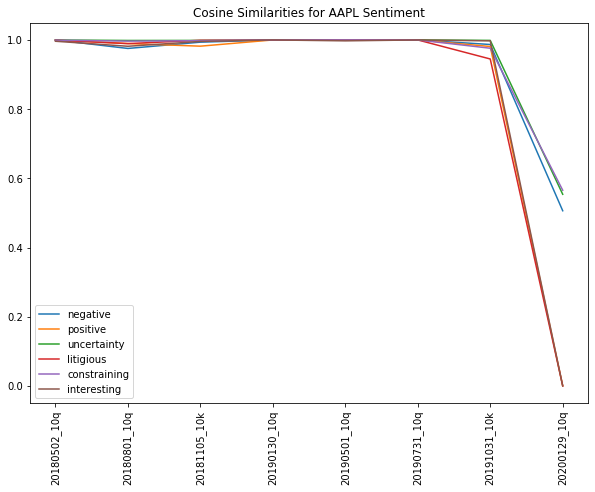

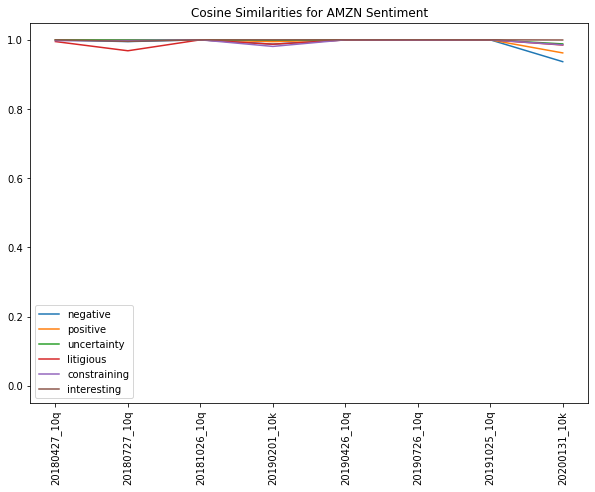

In [0]:
# chart cosince similarity values
cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_q_sentiments.items()}
    for ticker, ten_q_sentiments in sentiment_tfidf_ten_qs.items()}

all_dates = {
    ticker: [ten_q['file_date'] for ten_q in ten_qs]
    for ticker, ten_qs in ten_qs_by_ticker.items()} 

for ticker, values in cosine_similarities.items():
    plot_similarities(
        [values[sentiment] for sentiment in sentiments],
        all_dates[ticker][1:],
        'Cosine Similarities for {} Sentiment'.format(ticker.upper()),
        sentiments)